# Dog Classifier
## Classification

In [40]:
# Imports
import cv2
import itertools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import yaml
from IPython.display import display, Markdown as md
from pathlib import Path
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict

# Config
%matplotlib inline

In [41]:
# Config file
config = yaml.safe_load(open("classification.yml", encoding="utf-8"))

## Data Preparation
### Read Images
Read images as *ndarrays* in *images*. The directory of each image is its label. 

In [42]:
input_path = str(Path().resolve()) + config["input"]["folder"]

labels = list()
images = list()
for root, dirs, files in os.walk(input_path):
    for name in files:
        if name.endswith(config["input"]["extension"]):
            labels.append(Path(root).parts[-1])  # The folder is the label
            images.append(cv2.imread(os.path.join(root, name)))

# Convert lists to ndarrays
images = np.array(images)
labels = np.array(labels)

images_shape = images[0].shape

display("Images to classify: {0}".format(images.shape[0]))
display("Image's shape: {0}".format(images_shape))

'Images to classify: 450'

"Image's shape: (220, 220, 3)"

In [43]:
def display_one(a, title=""):
    """ Displays one image """
    plt.imshow(a)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
display_one(images[0], title="First image in 'images'")

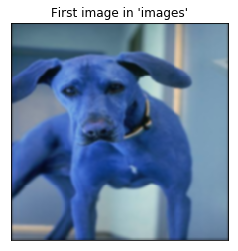

In [44]:
# Sort 'images' and 'labels' randomly
shuffle_index = np.random.permutation(images.shape[0])

images = images[shuffle_index]
labels = labels[shuffle_index]

# Now the first image in 'images' is another image
display_one(images[0], title="First image in 'images'")

In [45]:
# Reshape 'images' from 4 dim. to 2 dim.
print("'images' shape: {0}".format(images.shape))
images = images.reshape(images.shape[0], images.shape[1] * images.shape[2] * images.shape[3])
print("'images' shape: {0}".format(images.shape))

'images' shape: (450, 220, 220, 3)
'images' shape: (450, 145200)


### Train and test split

In [46]:
train_count = int(images.shape[0] * 0.8)
print("Train count: {0}".format(train_count))

X_train, X_test, y_train, y_test = images[:train_count], images[train_count:], labels[:train_count], labels[train_count:]

print("X_train shape: {0}".format(X_train.shape))
print("y_train shape: {0}".format(y_train.shape))
print("X_test shape: {0}".format(X_test.shape))
print("y_test shape: {0}".format(y_test.shape))

print("Labels: {0}".format(np.unique(labels)))

Train count: 360
X_train shape: (360, 145200)
y_train shape: (360,)
X_test shape: (90, 145200)
y_test shape: (90,)
Labels: ['flat_coated_retriever' 'maltese' 'rhodesian_ridgeback']


## Data Modeling
### SGD Classifier

In [47]:
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train)
y_pred_sgd = sgd_clf.predict(X_test)

c:\users\matias\miniconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


### Logistic Regression

In [48]:
log_reg = LogisticRegression(solver="lbfgs", random_state=42, multi_class="multinomial")
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)

c:\users\matias\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


## Model Evaluation
### Confusion Matrix

In [49]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """ This function prints and plots the confusion matrix """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [50]:
unique_labels = np.unique(labels)

conf_mx_test = confusion_matrix(y_test, y_pred_log_reg)

plt.figure(figsize=(8,8))
plot_confusion_matrix(conf_mx_test, classes=unique_labels)

### Scorings

In [51]:
display(md("**SGD Scores**"))
print(precision_score(y_test, y_pred_sgd, average="weighted"))
print(recall_score(y_test, y_pred_sgd, average="weighted"))
print(f1_score(y_test, y_pred_sgd, average="weighted"))

display(md("**Logistic Regression Scores**"))
print(precision_score(y_test, y_pred_log_reg, average="weighted"))
print(recall_score(y_test, y_pred_log_reg, average="weighted"))
print(f1_score(y_test, y_pred_log_reg, average="weighted"))

**SGD Scores**

0.7347135955831609
0.6888888888888889
0.6852189733593242


**Logistic Regression Scores**

0.7331765232974911
0.7333333333333333
0.7327060931899643


### Display Classification Results

flat_coated_retriever


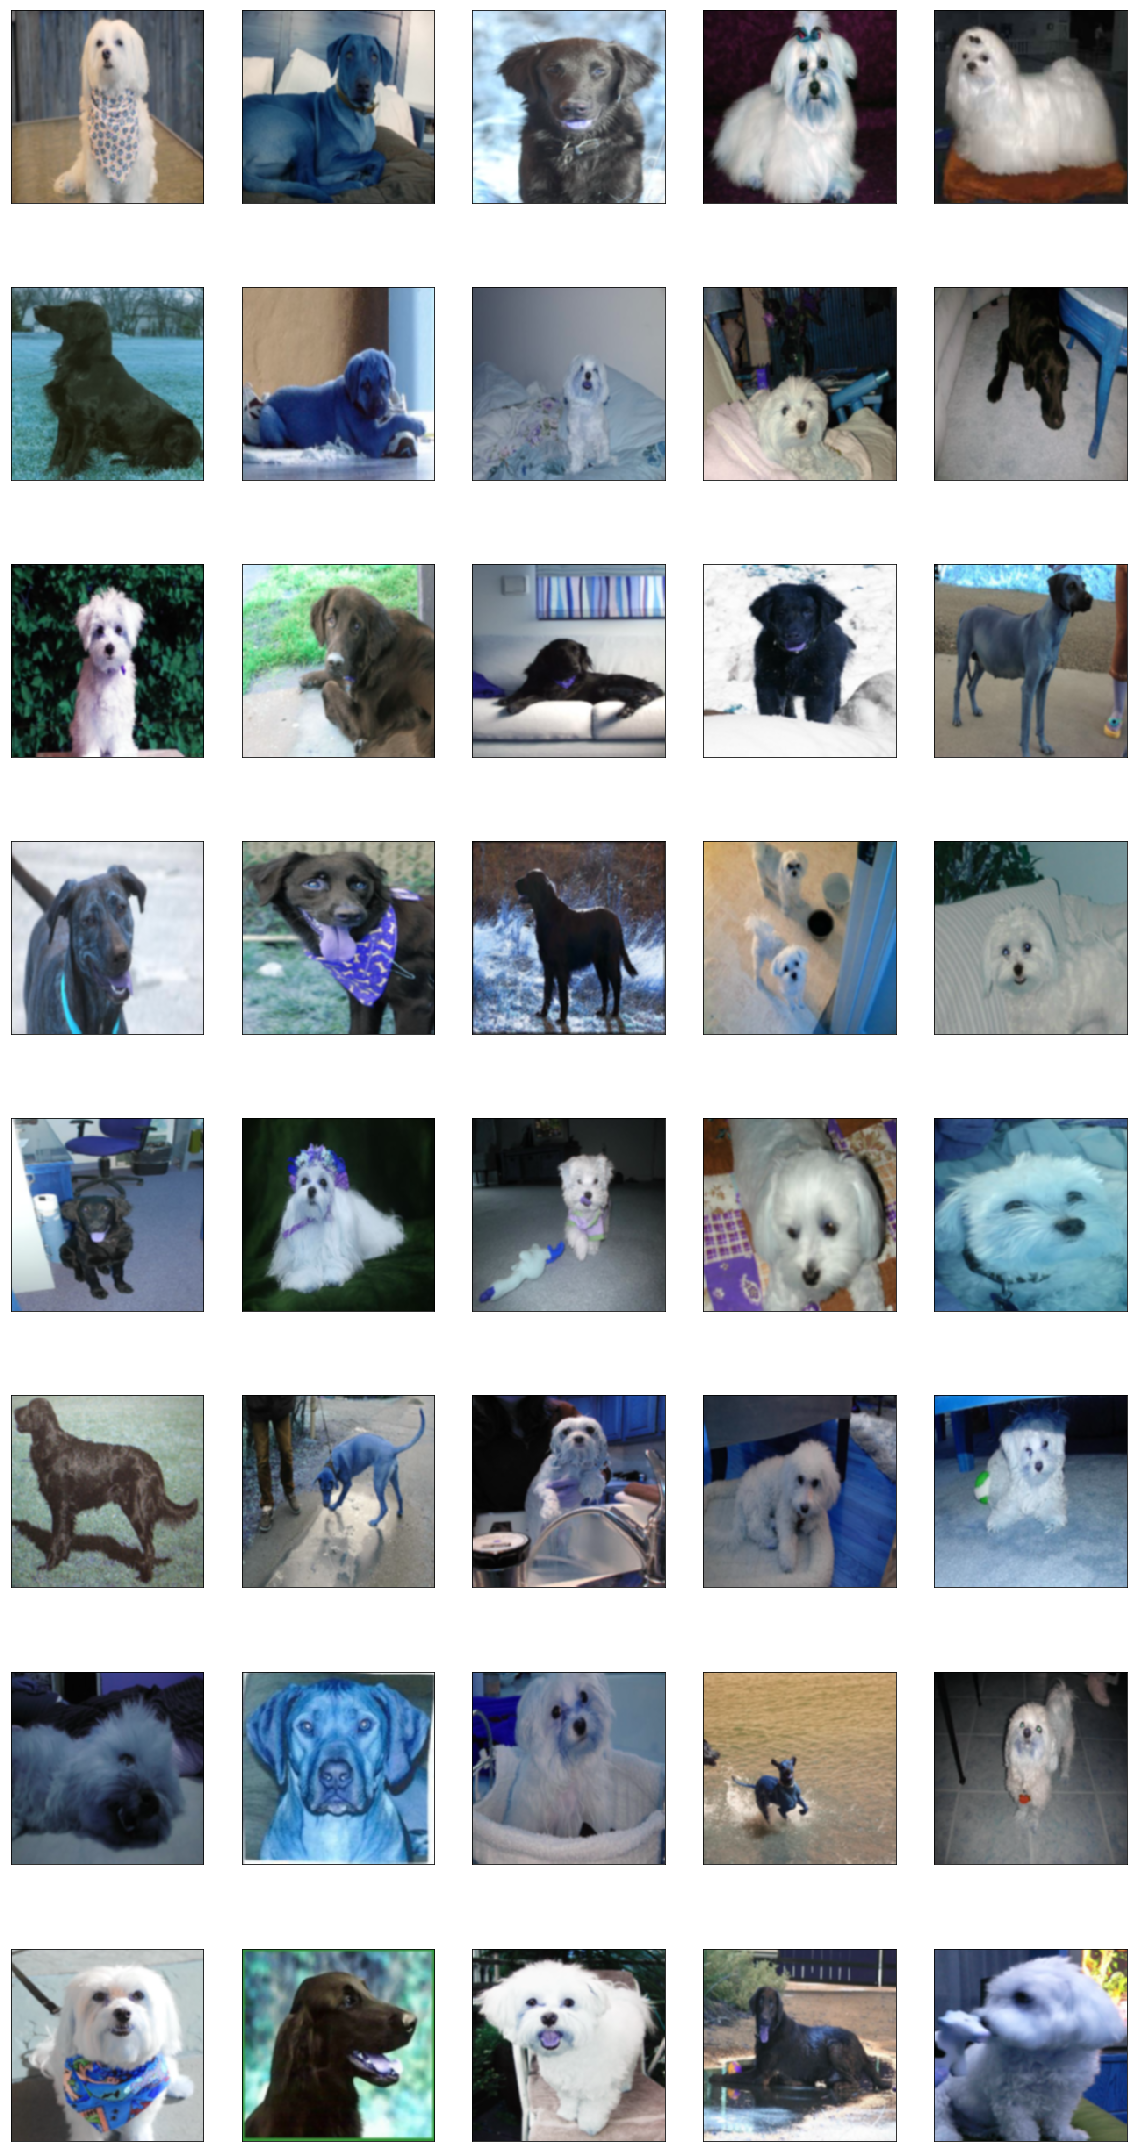

maltese


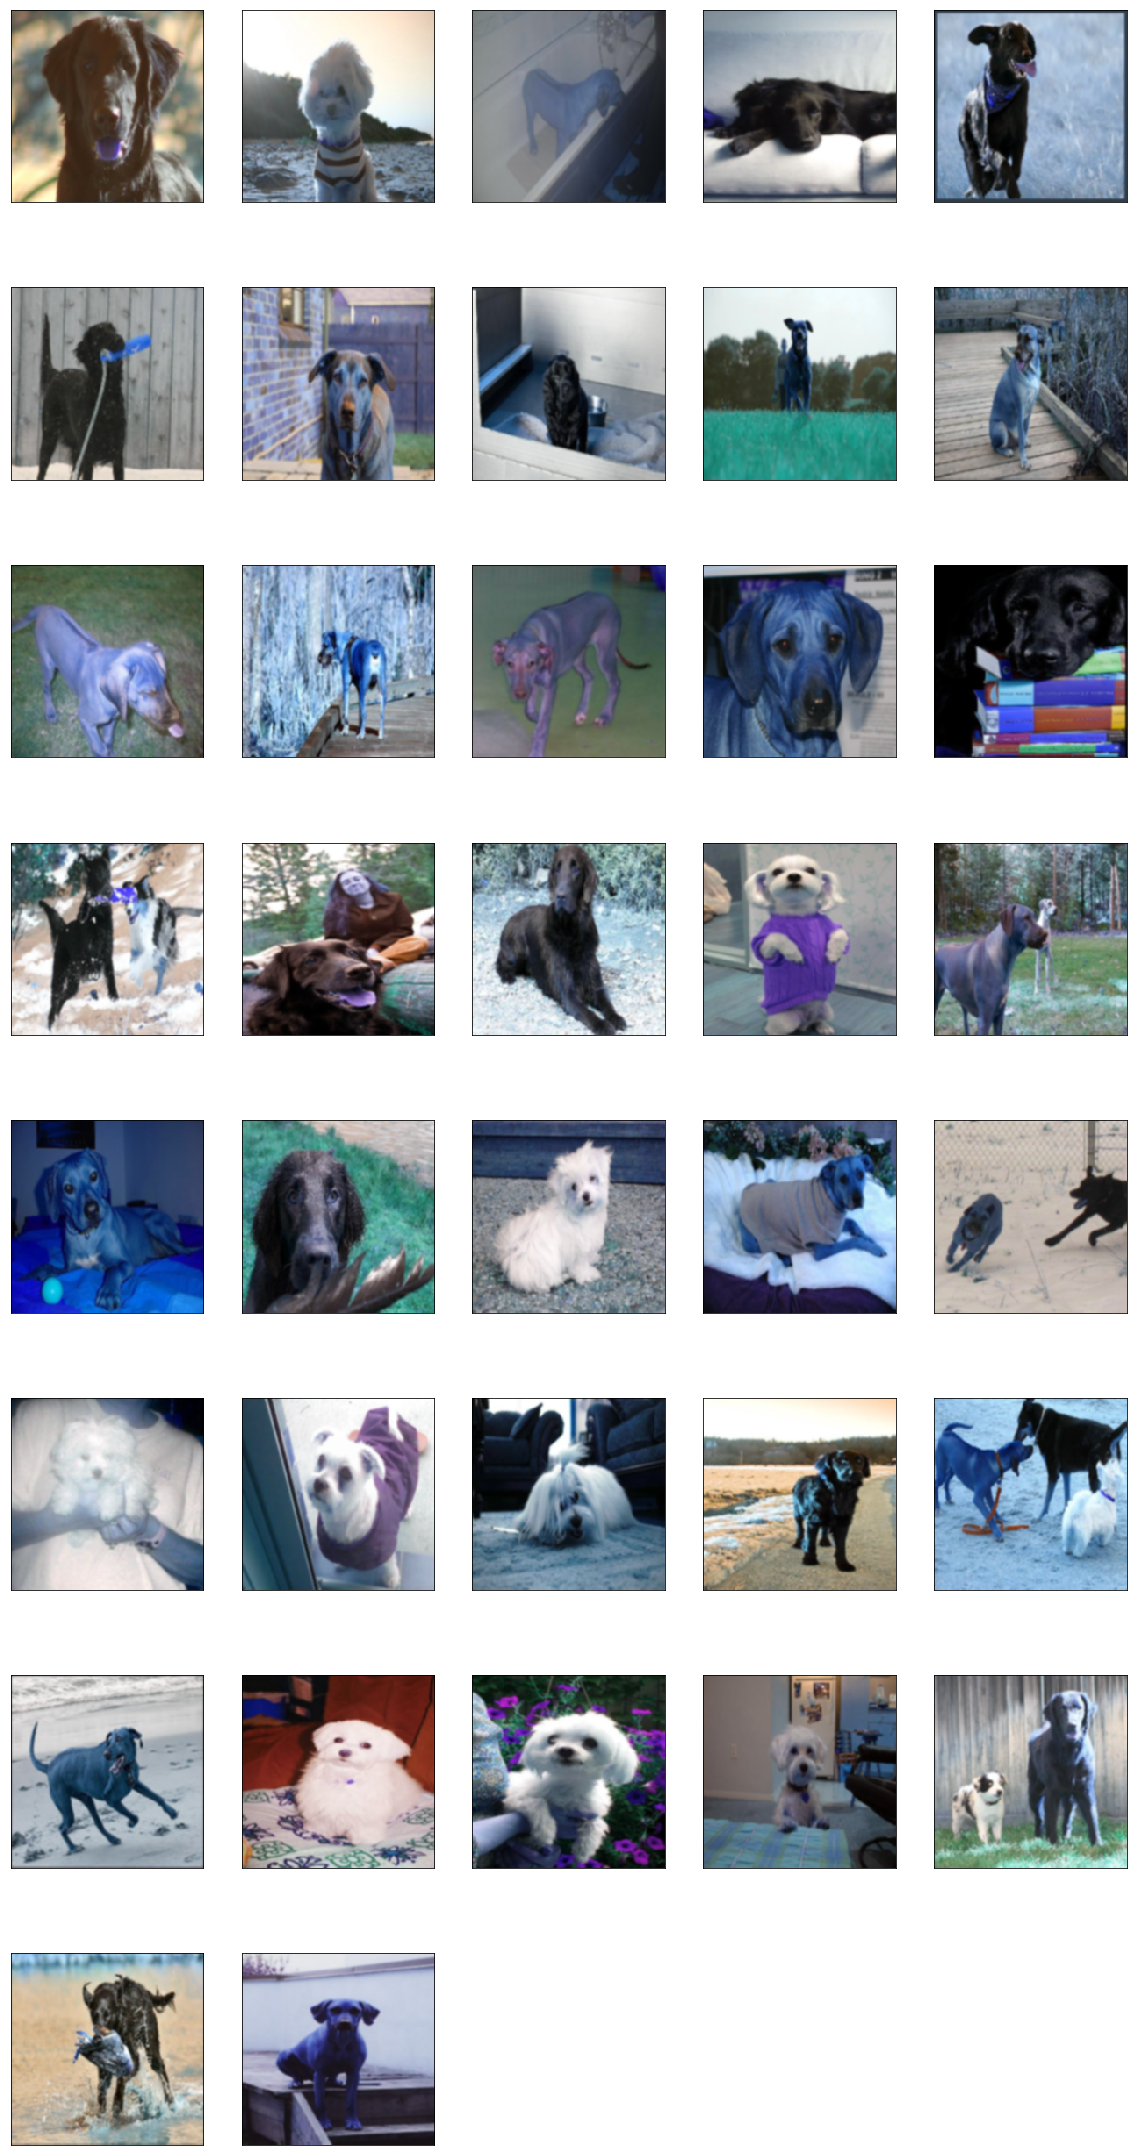

rhodesian_ridgeback


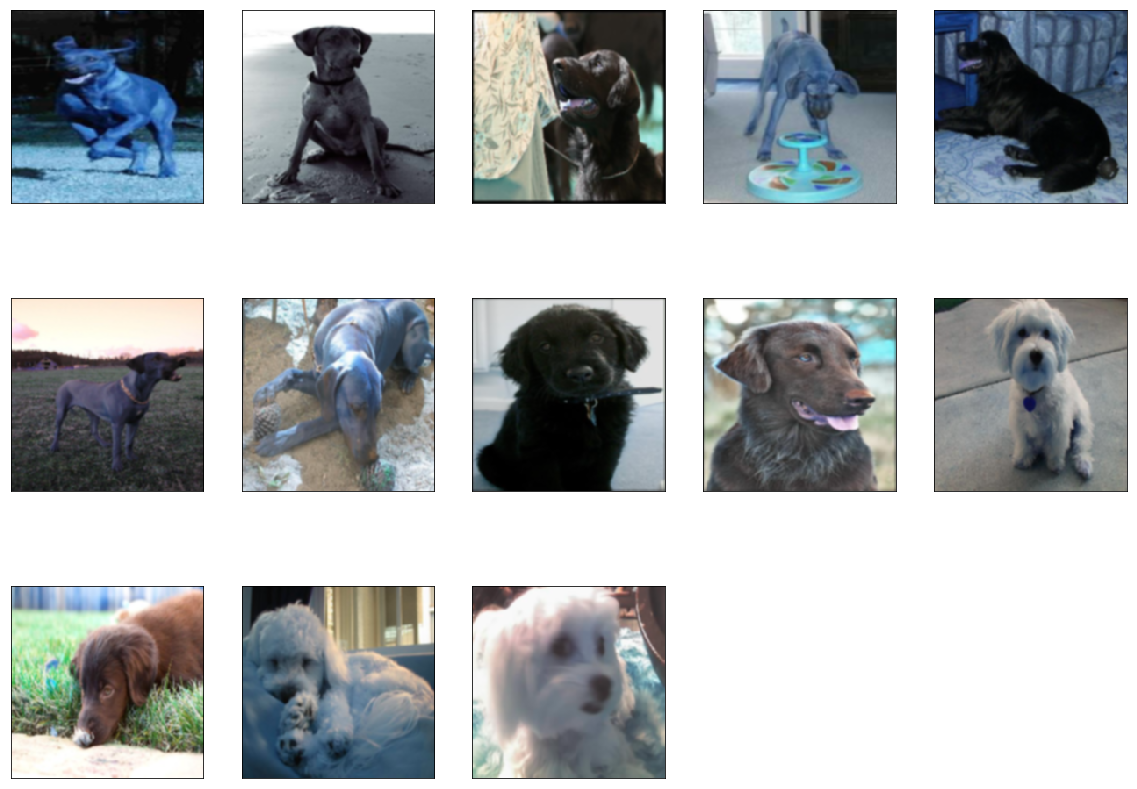

In [52]:
# Reshape 'X_test' images to display them
X_test = X_test.reshape(X_test.shape[0], int(images.shape[1] / images_shape[0] / 3), int(images.shape[1] / images_shape[1] / 3),
                        3)

# Print each label and images classificated with that label
for label in unique_labels:
    print(label)
    label_filter = y_pred_test == label
    X_test_label = X_test[label_filter]
    
    columns = 5
    rows = int(label_filter.sum() / columns) + 1
    plt.figure(figsize=(20, rows*5))
    
    for i, sample in enumerate(X_test_label):
        plt.subplot(rows, columns, i+1)
        plt.imshow(sample)
        plt.xticks([])
        plt.yticks([])
    
    plt.show()

